# Myers Briggs Type Indicator (MBTI) Project
### By The Introverts 
Nan Lin, Zack Pan, Ben Khuong, Tomohiko Ishihara, Donya Fozoonmayeh

### Table Of Contents:
- Background
- Problem Statement
- Exploratory Data Analysis
- Data Preprocessing
    - Text Cleaning
    - Feature Engineering
        - Text Vectorization
        - Feature Extraction
- Modeling
    - Naive Bayes
    - Logestic Regression
    - SVM
        - PCA
    - Random Forest
- Advanced Models
    - Xgboost
    - LightGBM
- Random Search
- Feature Importance
- Ensemble Learning: Voting Classifier
- Evaluation on ROC 
- Personality Prediction based on Tweets

<img src="Pictures/MBTIgrid.jpg" alt="Drawing" style="width: 500px;"/>

# **Background**

Myers Briggs Type Indicator (MBTI) is a personality questionnaire based on Carl Jung's theory of psychological types. The purpose of the test is to indicate people's various psychological preferences in their perception of the world and decision making. MBTI breaks down these preferences into four dichotomies or opposite pairs, which results in 16 different psychological types: 


1. Introversion vs Extroversion: "Where do you prefer to focus your attention and get your energy from?"
2. Sensing vs Intuition: "How do you prefer to take in information?"
3. Thinking vs Feeling: "How do you make decisions?"
4. Judging vs Perceiving: "How do you deal with the outer world?"

<img src="Pictures/personality_key.png" alt="Drawing" style="width: 500px;"/>

Although MBTI is not as popular as before, due to its poor validity and reliability, it is still widely used in the business sector. Therefore, we thought it would be interesting to look at a dataset we found on Kaggle. The dataset contains about 50 posts from 8600 individuals on a <a href="https://www.personalitycafe.com/myers-briggs-forum/">Personality Cafe forum</a>, along with their personality type. We thought it would be interesting to see if we could use machine learning to predict personality types, using posts. 

# **Problem Statement**

In this project, we will therefore apply traditional machine learning techniques to examine whether a person's MBTI correlates with their writing style. Our goal is the development of classifiers that are able to identify a person’s personality traits from text. This is a challenging problem, as even for a human observer it is not trivial to derive personality traits from written text. Also, our training dataset is not quite large. Taking this into account, we will develop models to predict each one of the four personality dimensions separately. Our assumption here is we can derive personality traits in each of the four dimensions from text independently. Considering that even a human reader will not be able to perfectly classify users based on their posts, we expect that the predictions of the developed classifiers will clearly correlate with the true labels, but we can not presuppose classifications that are nearly perfect.

Here we load the raw dataset, along with all the packages we used in our project:

In [1]:
import gc
import itertools
import re
import string 
import time
import warnings
from collections import Counter, defaultdict
from random import choice

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from helperfunctions.PrettyConfusionMatrix import print_cm

warnings.filterwarnings('ignore')

In [2]:
# Loading MBTI raw dataset
mbti = pd.read_csv('data/mbti_1.csv') 

# **1.) Exploratory Data Analysis**

Overview of data

In [3]:
mbti.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


Since the raw data was posts from a forum, we had to do a lot of preprocessing and feature engineering.

First, lets take a look at the distribution of the MBTI personality types.

<BarContainer object of 16 artists>

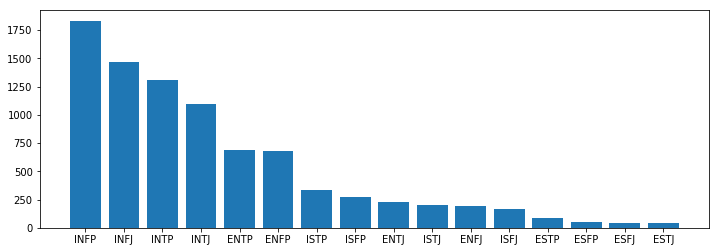

In [4]:
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

As it can be clearly observed in the above plot, there is a huge imbalance between the personality types. Therefore, instead of just looking at the personality type, we decided to look at each aspect of personality.

In [5]:
# Personality type for each aspect 

# Extroversion vs. Introversion
mbti['EorI']= mbti['type'].apply(lambda x:x[0])

# Intuition vs. Sensing
mbti['NorS']= mbti['type'].apply(lambda x:x[1])

# Thinking vs. Feeling
mbti['TorF']= mbti['type'].apply(lambda x:x[2])

# Judging vs. Perceiving
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

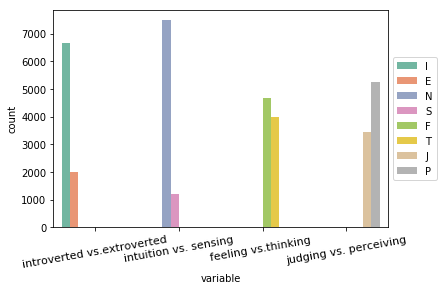

In [6]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Here, we look at the number of users for each personality aspect. Again, there is an imbalance between the types for some of the groups, especially for data in demension *Introverted vs Extroverted* and *Inituition vs Sensing*

Due to the imbalance we have with our data, we choose **F1-score** and **AUC-ROC** as our matrics instead of accuracy to evaluate performance of classfiers.

In [7]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

# **2.) Data Preprocessing**

In [8]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


### Text Cleaning
In this section, we clean the text and standardize it:
1. The posts for each user are separatered by "|||", therefore, we removed them
2. Removed links, punctuation, MBTI-types words(a lot of users refer to their own personality types in their posts)
3. Lowercase
4. Lemmatized words
5. Removed stop words

In [9]:
# finding personality types list 
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]
types

['infj',
 'entp',
 'intp',
 'intj',
 'entj',
 'enfj',
 'infp',
 'enfp',
 'isfp',
 'istp',
 'isfj',
 'istj',
 'estp',
 'esfp',
 'estj',
 'esfj']

In [10]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer()
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        
        # Removing personality types
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

It takes about **15 minutes** to run the above function for cleaning the posts. Please uncomment the line below to run the above function. 

In [11]:
# To save time, we load the preprocessed posts
processed_post = pd.read_csv('data/mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


### **Vectorizing Personality Types**
Here we convert each personality aspect into a binary code. For example, an introverted person would be 0 and an extroverted person would be 1. 

In [12]:
# A type consists of 4 capitals and each capital corresponds to 2 possible characteristics.
# For later encoding and modeling issues, let's tranfer them into separate binary code.
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
# transfer column 3-6 into binary code.
def type_preprocess(df):
    for i in range(2,6):
        df.iloc[:,i] = df.iloc[:,i].map(type_map)
    return df

In [13]:
mbti = type_preprocess(mbti)

In [14]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576


## 3. **Feature Engineering**

### 3.1 Vectorizing Posts
Using TFIDF, we created a bag of words representation of each user's posts.

In [15]:
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


In [16]:
# TfidfVectorizer
# Parameters used here are the  best for model performance
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.85, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(processed_post['processed_posts'])
word_tfidf = vectorizer_tfidf.transform(processed_post['processed_posts'])
word_tfidf_df = pd.DataFrame(data = word_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names())

In [17]:
word_tfidf_df.head()

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,across,...,year ago,year old,yep,yes,yesterday,yet,young,younger,youtube,yup
0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.067997,0.000000,0.083075,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.00000,0.038307,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.12246,0.044400,0.000000,0.106856,0.0,0.0,0.0,0.0,0.064077,0.0,...,0.000000,0.063801,0.000000,0.060355,0.0,0.0,0.0,0.0,0.0,0.081823
3,0.00000,0.071834,0.066683,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.059121,0.000000,0.055929,0.0,0.0,0.0,0.0,0.0,0.000000


### 3.2 Manual Features

#### 3.2.1 Sentiment Score
*Caution: Takes a few minutes to run.*

In [18]:
# Sentiment Score of clean post
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post['processed_posts'][i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


In [19]:
mbti['Sentiment'] = scores

#### Additional Cleaning
Here we get rid of `NaN` sentiment scores. We also scale negative numbers with `MinMaxScalar`, since it can't be handled by Naive Bayes.

In [20]:
# NaNs were found: 
mbti.fillna(value=0, inplace=True)
# Naive Bayes can't handle negatives? Scale with MinMax 
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(mbti['Sentiment']).reshape(-1, 1))
sentiment_scaled = min_max_scaler.transform(np.array(mbti['Sentiment']).reshape(-1, 1))
mbti['Sentiment'] = sentiment_scaled

#### 3.2.2 Ellipses count

Counting number of ellipsies used per user.

In [21]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in mbti['posts']]
# Append to dataset 
mbti['Ellipses'] = ellipses_count

#### 3.2.3 Exclamation count
Counting number of exclamation marks used per user. 

In [22]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Exclamation'] = exclamation_count

#### 3.2.4 Question count
Counting number of question marks used per user. 

In [23]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Question'] = question_count

#### 3.2.5 Link count
Counting number of links used per user. 

In [24]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to dataframe
mbti['Links'] = link_count

#### 3.2.6 Picture count
Counting the number of pictures used per user. 

In [25]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['Picture'] = question_count

#### 3.2.7 Emojies count
Counting the number of Slack-style(e.g. `:smile:`) and most common text-style(e.g. `:)`) emojies per user.

In [26]:
def find_emoji(text):
    # REMOVE LATER ON
    text = text.lower()
    
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [27]:
mbti['Emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

#### 3.2.8 Upper case count
Counting the number of uppercase words per user.

In [28]:
def del_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    return regex.sub("", text)

In [29]:
temp = mbti['posts'].apply(lambda x: del_punct(x))
mbti['Upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [30]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,Sentiment,Ellipses,Exclamation,Question,Links,Picture,Emojies,Upper
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900,0.996199,8,3,18,24,6,4,13
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756,0.999350,18,0,5,9,8,14,82
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900,0.999250,13,4,12,4,0,10,26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324,0.999250,23,3,11,2,0,0,57
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576,0.995699,20,1,10,6,2,1,35


## **4.) Modeling**

### Base Model: Multinomial NB & Logistic Regression

In [124]:
# for saving time, load the data we have done in terms of feature engineering.
mbti = pd.read_csv("data/mbti_FE.csv")
target = mbti.iloc[:,2:6]

X_tf = pd.concat([mbti.iloc[:,6:],word_tfidf_df],axis=1)
# X_ct = pd.concat([mbti.iloc[:,6:],word_ct_df],axis=1)
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,Sentiment,Ellipses,Exclamation,Question,Links,Picture,Emojies,Upper
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900,0.996199,8,3,18,24,6,4,13
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756,0.999350,18,0,5,9,8,14,82
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900,0.999250,13,4,12,4,0,10,26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324,0.999250,23,3,11,2,0,0,57
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576,0.995699,20,1,10,6,2,1,35


Here we set a function to collect models' performances on roc

In [32]:
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    
    classes = {'EorI':['Extrovert','Introvert'], 'NorS':['Sensing', 'Intuition'],
             'TorF':['Thinking','Feeling'],'JorP':['Perceiving','Judging']}

    fig, axs = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='b')
    axs = axs.flatten()
    k=0
    
    v_max = max(np.ndarray.flatten(np.array(list(cm.values()))))
    
    for col in cm.keys():
        x = axs[k].imshow(cm[col], cmap=cmap, vmin=0.1, vmax=.5) # interpolation changes the blurriness of the squares 
        axs[k].set_title(types[col], fontweight='bold')
        tick_marks = np.arange(len(classes[col]))
        axs[k].set_xticks(tick_marks)
        axs[k].set_xticklabels(labels = classes[col])
        axs[k].set_yticks(tick_marks)
        axs[k].set_yticklabels(labels = classes[col])
        axs[k].grid(which='minor', color='black')
        axs[k].axhline(0.5, color='black', linewidth=0.5) # horizontal lines
        axs[k].axvline(0.5, color='black', linewidth=0.5)
        for i, j in itertools.product(range(cm[col].shape[0]), range(cm[col].shape[1])):
            axs[k].text(j, i, format(cm[col][i,j], '.1%'),
                     horizontalalignment="center",
                     color="white" if cm[col][i, j] > v_max/1.5 else "black") # if color is darker, use white 
        axs[k].set_ylabel('True label')
        axs[k].set_xlabel('Predicted label')
        plt.tight_layout()
        k+=1
    
    fig.subplots_adjust(right=0.93)
    cbar_ax = fig.add_axes([0.95, .15, 0.01, .65])
    fig.colorbar(x, cax=cbar_ax)

In [33]:
def get_plot_data(probabilities):
    '''
    Calculates average ROC and Precision vs Recall curves over n_splits of stratified shuffle splits. 
    Not all thresholds are chosen equally, thus different splits have different array lengths of FPR, TPR,
    precision, and recall. In order to average we need the same array length. We will interpolate tpr values 
    between 0 and 1 in 0.1 increments. This gives an average of a set of *estimated* ROC and Precision vs 
    recall estimates. 

    Function returns a dictionary with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'.  
    Within each class value contains another dictionary with keys 'base_x', 'est_tpr', 'roc_auc',
    'est_pr', and 'auc_pr'. 'base_x' is the range of x values used to interpolate both the TPR and precision. 
    '''
    model_data = defaultdict()
    base_x = np.linspace(0,1,101)
        
    for types in probabilities.keys():
        model_data[types] = {'base_x':base_x, 'est_tpr':np.zeros(101), 'auc_roc':[], 'est_pr':np.zeros(101),
                             'auc_pr':[]} 
        total_splits = len(probabilities[types]) 
        for split in probabilities[types]:
            y_scores = split[0] # split[0] is the model probability of predicting a 1
            y_true = split[1] # split[1] is the true test values for that split
            fpr, tpr, thresholds = roc_curve(y_true,y_scores) # used for interpolation
            precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
            model_data[types]['est_tpr'] += np.interp(base_x, fpr, tpr) # Add est_tpr 
            model_data[types]['est_pr'] += np.interp(base_x, recall[::-1], precision[::-1]) # Add est_precision 
            model_data[types]['auc_roc'].append(auc(fpr, tpr)) # Append AUC 
            model_data[types]['auc_pr'].append(auc(recall, precision)) # Append AUC 
        model_data[types]['est_tpr'] = model_data[types]['est_tpr'] / total_splits # Average TPRs 
        model_data[types]['est_pr'] = model_data[types]['est_pr'] / total_splits # Average TPRs 
        model_data[types]['auc_roc'] = np.mean(model_data[types]['auc_roc']) # Average AUC-ROC
        model_data[types]['auc_pr'] = np.mean(model_data[types]['auc_pr']) # Average PR
        
    return model_data

In [34]:
def threshold_search(y_true, y_proba):
    '''
    searching a threshold to find the best f1-score
    '''
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
#     search_result = {'threshold': best_threshold, 'f1': best_score} print if u want
    return best_score

In [35]:
def model(model, X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[(p1,y1),(p2,y2),(p3,p3)...],[(p1,y1),(p2,y2),(p3,y3)...],...]
    '''
    
    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    model_data = defaultdict()
    cms = defaultdict()
    df = pd.DataFrame(columns=['Average AUC', 'Average F_score'])

    types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    
    
    t = time.time()
    for col in target.columns:
        y = target[col]
        all_auc = []
        all_accuracies = []
        f_score = []
        model_data[col] = []
        avg_cm = np.zeros(4).reshape(2,2).astype(int)
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test]
            model.fit(X_train, y_train)
            probabilities = model.predict_proba(X_test)
            score = probabilities[:, 1]
            preds = model.predict(X_test)
            model_data[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
            fscore = threshold_search(y_test,score)
            f_score.append(fscore)
            avg_cm += confusion_matrix(y_test, preds,[1,0])
        avg_cm = avg_cm/nsplits 
        avg_cm = avg_cm/np.sum(avg_cm) 
        cms[col] = avg_cm
        df.loc[types[col]] = [np.mean(all_auc),np.mean(f_score)]
    print(df)
    plot_confusion_matrix(cms)
    print(f"Time use:{time.time()-t:.3f}s")

    return get_plot_data(model_data)

### Performance Evaluation
#### Naive Bayes

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.603402         0.399195
Intuition vs. Sensing             0.556657         0.257911
Thinking vs. Feeling              0.686647         0.667340
Judging vs. Perceiving            0.567650         0.753487
Time use:3.094s


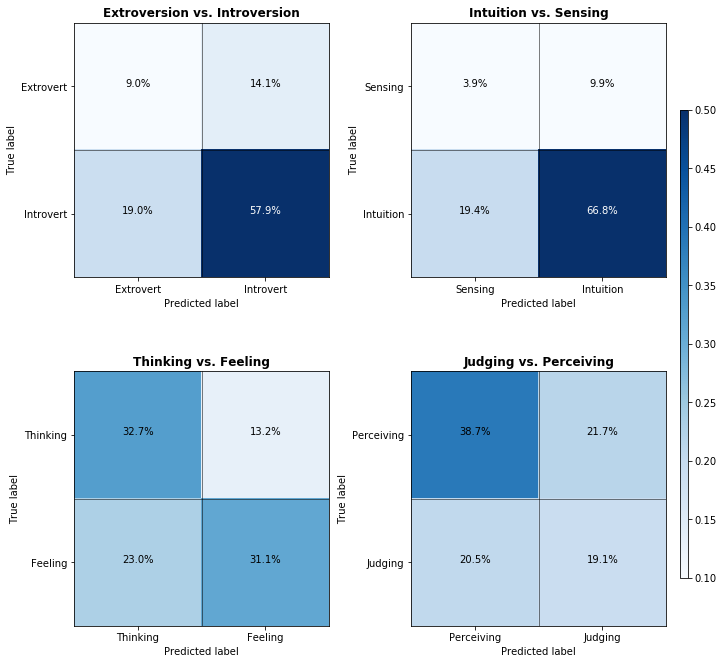

In [36]:
MNB = MultinomialNB()
mnb_tf_model = model(MNB, X_tf, target, nsplits=4)

#### Logestic Regression

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.744077         0.502272
Intuition vs. Sensing             0.744017         0.415696
Thinking vs. Feeling              0.862341         0.782159
Judging vs. Perceiving            0.711018         0.771616
Time use:30.489s


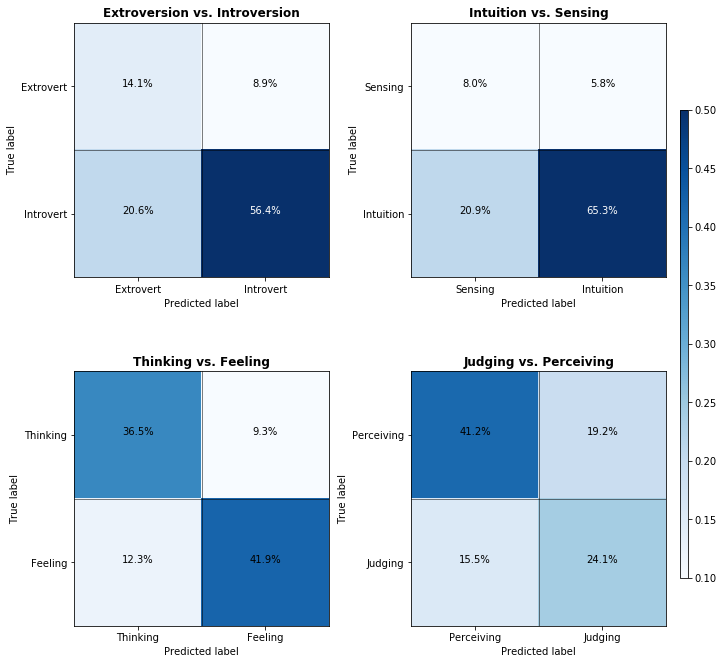

In [37]:
LR = LogisticRegression(class_weight='balanced')
lr_tf_model = model(LR, X_tf, target, nsplits=4)

*Notice:* the great gap between AUC and accuracy in EorI, IorS, both of which are unbalanced. But we can deal with it in the following models.

### Support Vector Machines

In order to perform SVM, we first perform PCA and keep the first **20** principal components

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.480443         0.375208
Intuition vs. Sensing             0.510291         0.246375
Thinking vs. Feeling              0.588905         0.630497
Judging vs. Perceiving            0.504573         0.752874
Time use:333.596s


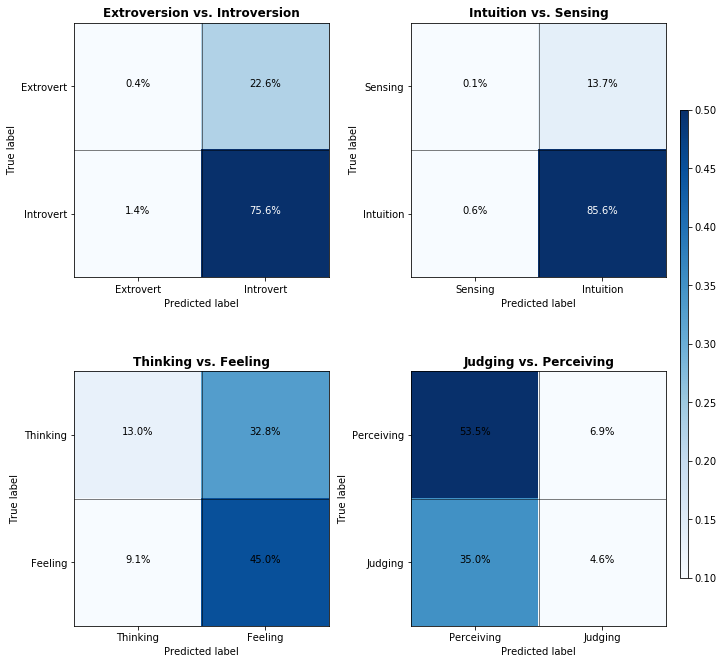

In [42]:
pca_tfidf = PCA(n_components=20)
X_tfidf_pca_50 = pd.DataFrame(pca_tfidf.fit_transform(X_tf))

SVM = SVC(class_weight="balanced", probability=True)
svm_tf_pca20_model = model(SVM, X_tfidf_pca_50, target, nsplits=4)

### Random Forest

In [43]:
RF = RandomForestClassifier(n_estimators=300, max_depth=7,class_weight='balanced')

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.714063         0.474202
Intuition vs. Sensing             0.687895         0.346591
Thinking vs. Feeling              0.819512         0.743238
Judging vs. Perceiving            0.672663         0.760599
Time use:126.524s


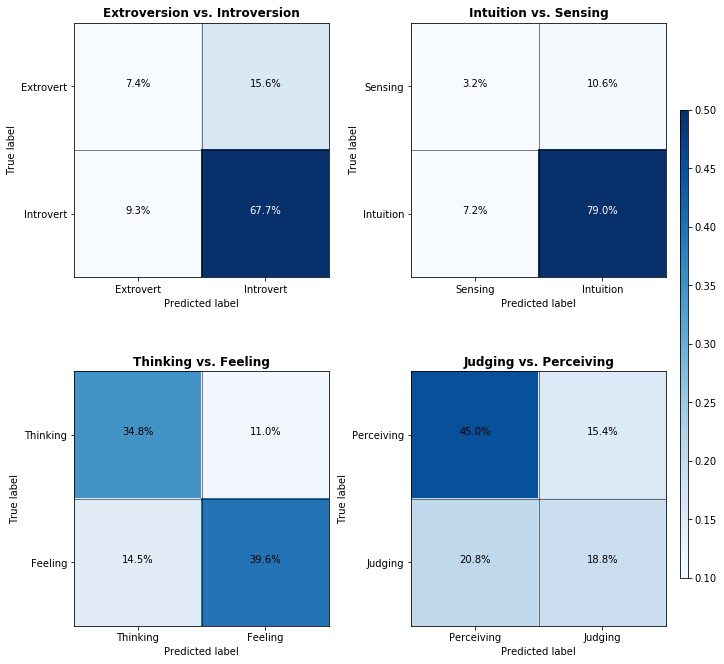

In [44]:
rf_tf_model = model(RF, X_tf, target, nsplits=4)

## Advanced Model: Xgboost & Lightgbm

### Xgboost

In [45]:
XGB = XGBClassifier(eval_metric='auc')

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.715873         0.478302
Intuition vs. Sensing             0.684918         0.338298
Thinking vs. Feeling              0.836105         0.756368
Judging vs. Perceiving            0.695327         0.768472
Time use:475.052s


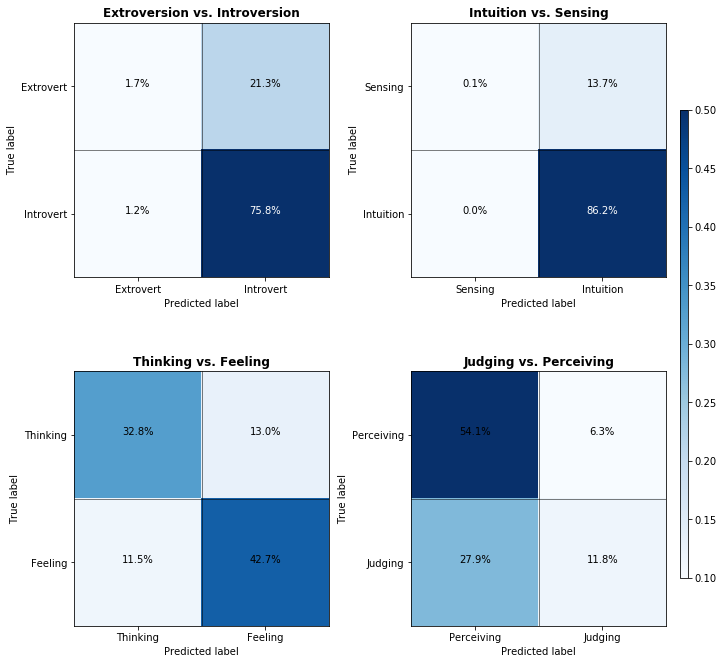

In [46]:
xgb_tf_model = model(XGB, X_tf, target, nsplits=5)

### LightGBM

In [47]:
LGB = lgb.LGBMClassifier(eval_metric='auc',is_unbalance=True)

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.723015         0.488457
Intuition vs. Sensing             0.694889         0.350751
Thinking vs. Feeling              0.848587         0.768413
Judging vs. Perceiving            0.686088         0.770094
Time use:622.702s


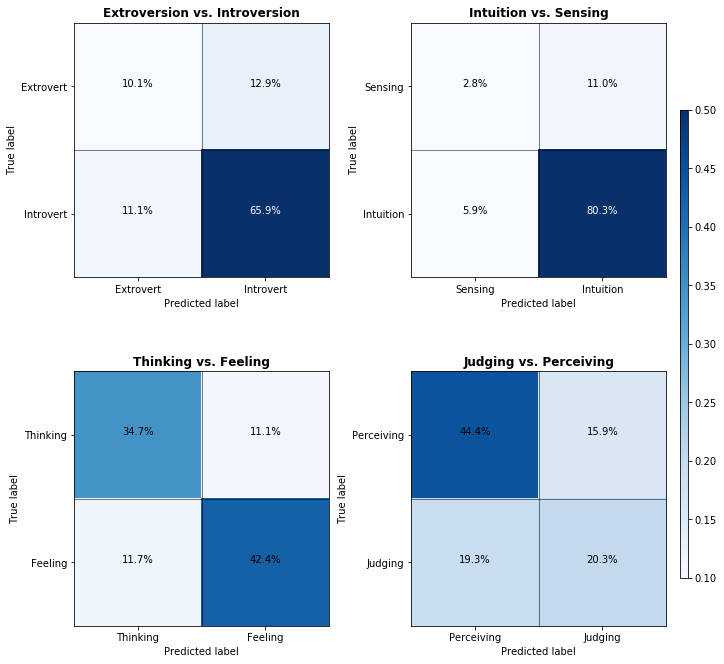

In [48]:
lgb_tf_model = model(LGB, X_tf, target, nsplits=5)

Lightgbm performs a bit better than xgboost in terms of AUC and Accuracy and more importantly, saves much more time. We decide to go further on lightgbm and dataset containing tfidf vectors(X_tf).

## Random Search
Iteration=20 takes nearly 25mins to run

In [49]:
kf = StratifiedShuffleSplit(n_splits=5, random_state=420)

# loop for random search
n_iterations=20

print ("Random search start...")
for col in target.columns:
    print(f"* {types[col]} ")
    y = target[col]
    roc_auc_mean = []
    dict_list = []
    for i in range(0, n_iterations):

        param_dist = {'n_estimators' : choice([250,300,350,400,450]),
                  'bagging_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                  'learning_rate': choice([0.05, 0.1, 0.3, 0.5]),
                  'is_unbalance': True,
                  'max_bin': choice([3, 5, 10, 15, 18, 20, 25]),
                  'boosting_type' : choice(['gbdt', 'dart']),
                  'max_depth': choice([2,3,4,5]),      
                  'feature_fraction': choice([0.7, 0.8, 0.9]),
                  'lambda_l1': choice([0, 10, 20, 30, 40]),
                  'objective': 'binary', 
                  'metric': 'auc'} 

        roc_l = []

        for train, test in kf.split(X_tf,y):

            X_train, X_test, y_train, y_test = X_tf.loc[train], X_tf.loc[test], y[train], y[test]

            # training
            gbm = lgb.LGBMClassifier(**param_dist)
            gbm.fit(X_train,y_train)
            # predicting
            y_pred = np.round(gbm.predict_proba(X_test)[:,1],3)
            roc = roc_auc_score(y_test, y_pred)
            roc_l.append(roc)

        roc_array = np.asarray(roc_l)

        roc_auc_mean.append(roc_array.mean())
        dict_list.append(param_dist)
        gc.collect()

    results_pd = pd.DataFrame({"roc_auc_mean": roc_auc_mean,"parameters": dict_list})    

    results_pd.sort_values("roc_auc_mean", ascending = False, axis = 0, inplace = True)
    top_pd = results_pd.head(1)
    print(f"--> Best AUC:{top_pd.iloc[0,0]} using {top_pd.iloc[0,1]}")

Random search start...
* Extroversion vs. Introversion 
--> Best AUC:0.7319865269461079 using {'n_estimators': 300, 'bagging_fraction': 0.5, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'dart', 'max_depth': 4, 'feature_fraction': 0.7, 'lambda_l1': 30, 'objective': 'binary', 'metric': 'auc'}
* Intuition vs. Sensing 
--> Best AUC:0.7264594474153299 using {'n_estimators': 300, 'bagging_fraction': 0.7, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 25, 'boosting_type': 'gbdt', 'max_depth': 5, 'feature_fraction': 0.8, 'lambda_l1': 30, 'objective': 'binary', 'metric': 'auc'}
* Thinking vs. Feeling 
--> Best AUC:0.854009408745857 using {'n_estimators': 300, 'bagging_fraction': 0.8, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 10, 'boosting_type': 'dart', 'max_depth': 2, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}
* Judging vs. Perceiving 
--> Best AUC:0.7029896369607669 using {'n_estimators': 450, 'bagging_

In [50]:
def lgbmodel(X, target, nsplits=4):
    '''
    Estimates probabilities for observations being in class 1.

    Function feeds total probabilities into average ROC. Total probabilities is a dictionary 
    with keys of class 'EorI', 'NorS', 'TorF', and 'JorP'. Within each class value contains a 
    list of probabilities for each split.

    Example: total_probabilities['EorI'] contains [[p1,p2,p3...],[p1,p2,p3...],...]
    '''

    kf = StratifiedShuffleSplit(n_splits=nsplits, random_state=420)
    total_probabilities = defaultdict()
    cms = defaultdict()
    df = pd.DataFrame(columns=['Average AUC', 'Average F_score'])
    
    types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    
    para_list = [{'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}]
     
    classes = {'EorI':['Extroverts','Introverts'], 'NorS':['Sensing', 'Intuition'],
             'TorF':['Thinking','Feeling'],'JorP':['Perceiving','Judging']}
    
    
    t = time.time()
    for i,col in enumerate(target.columns):
        param = para_list[i]
        y = target[col]
        all_auc = []
        f_score = []
        total_probabilities[col] = []
        avg_cm = np.zeros(4).reshape(2,2).astype(int)
        for train, test in kf.split(X, y):
            X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y[train], y[test] 
            gbm = lgb.LGBMClassifier(**param)
            gbm.fit(X_train,y_train)
            # predicting
            probabilities = gbm.predict_proba(X_test)
            preds = gbm.predict(X_test)
            score = probabilities[:, 1]
            total_probabilities[col].append((score, y_test))
            all_auc.append(roc_auc_score(y_test,score))
            avg_cm += confusion_matrix(y_test, preds,[1,0])
            fscore = threshold_search(y_test,score)
            f_score.append(fscore)
        avg_cm = avg_cm/nsplits 
        avg_cm = avg_cm/np.sum(avg_cm) 
        cms[col] = avg_cm
        df.loc[types[col]] = [np.mean(all_auc),np.mean(f_score)]
    print(df)
    plot_confusion_matrix(cms)
    print(f"Time use:{time.time()-t:.3f}s")

    return get_plot_data(total_probabilities)

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.732416         0.497408
Intuition vs. Sensing             0.722859         0.377706
Thinking vs. Feeling              0.853266         0.771323
Judging vs. Perceiving            0.701226         0.766264
Time use:217.189s


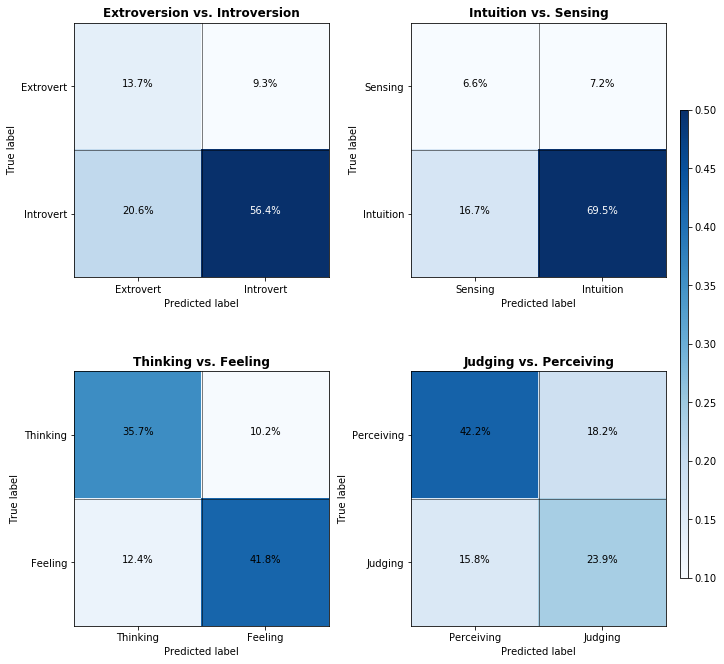

In [51]:
lgb_tf_model_t = lgbmodel(X_tf, target, nsplits=5)

### Feature Importance

In [52]:
para_list = [{'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'},
              {'n_estimators': 450, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}]

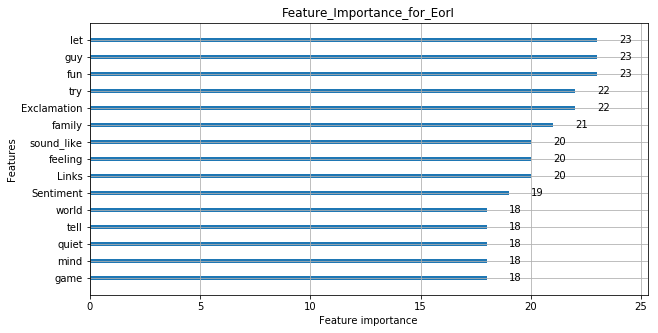

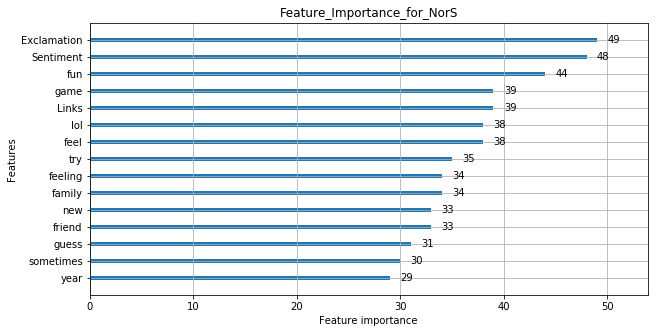

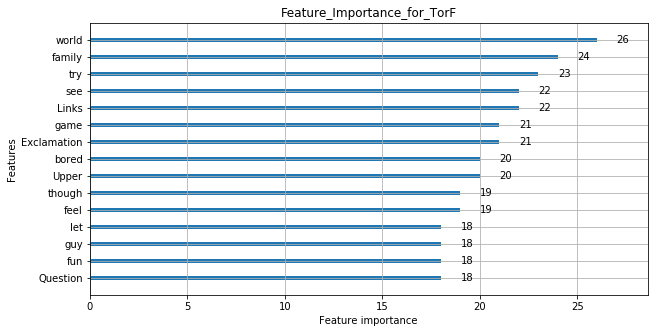

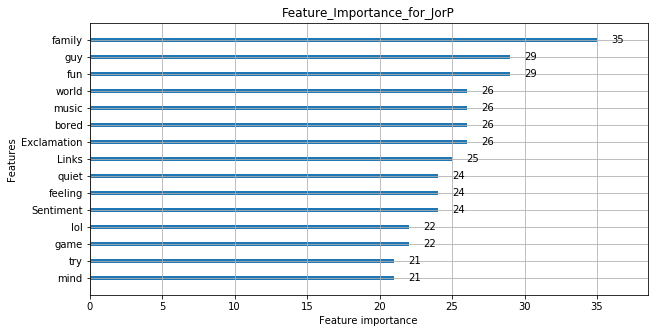

In [53]:
X_tf.drop(['ni','ne','sx','fe'], axis=1,inplace=True)
for i in range(4):
    label = target.columns
    y = target.values[:,0]
    # fit model on training data
    LGB = lgb.LGBMClassifier(**para_list[i])
    LGB.fit(X_tf, y)
    # plot feature importance
    ax = lgb.plot_importance(LGB, max_num_features=15)

    fig = ax.figure
    fig.set_size_inches(10, 5)
    plt.title(f"Feature_Importance_for_{label[i]}")
    plt.show()

#### Interpretation:
To examine the most distinctive words for each of the four personality dimensions, we visualize the feature importances of the LGB classifiers trianed on TFIDF vectorizer. The results seem align with our common assumptions. E.g., we can expect an extroverted person to be more likely to use words like *guys*, *fun* and *exclamation mark !* than an introvert. A person labelled as a feeling type might more often use *board*, *feel*, *upper case words* in their posts than a thinking character. In case of some words, the influence of personality types on their usage is less obvious, and some of these words might be the result of mere chance. Specifically, words like *family*, *try* share similar importance among all four aspects. 

## Ensemble Voting

In [56]:
pm =  {'n_estimators': 450, 'bagging_fraction': 0.5, 
       'learning_rate': 0.05, 'is_unbalance': True, 
       'max_bin': 18, 'boosting_type': 'gbdt', 
       'max_depth': 3, 'feature_fraction': 0.9, 
       'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'}
Lgbm = lgb.LGBMClassifier(**pm)

voting_clf = VotingClassifier(estimators = [('lgbm', Lgbm), 
                                            ('xgb', XGB),
                                            ('lr',LR),
                                            ('rf',RF)],
                              voting = 'soft')

                               Average AUC  Average F_score
Extroversion vs. Introversion     0.736943         0.497121
Intuition vs. Sensing             0.744135         0.409121
Thinking vs. Feeling              0.861766         0.780045
Judging vs. Perceiving            0.672306         0.762140
Time use:978.720s


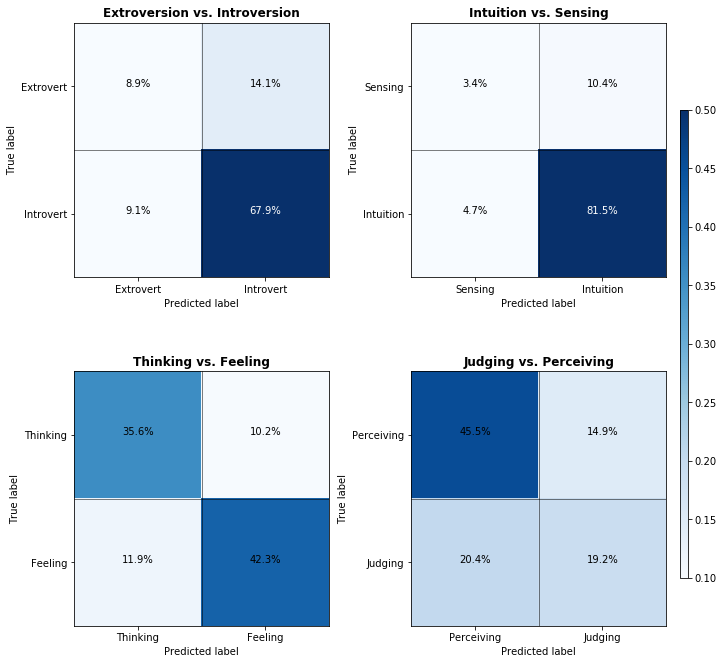

In [57]:
voting = model(voting_clf, X_tf, target, nsplits=5)

## Performance Evaluation 
AUC-ROC plot

In [58]:
def auc_plot(model_list, model_names, plot_type):
    '''
    From model list and model names, plots ROC curves for each class on a 2x2 grid.
    Add more colors to colors list if number of model exceeds current list length.
    '''
    fig, axs = plt.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='b')
    axs = axs.flatten()
    abbrev = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                     'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}
    colors = ['b','g','c','m','y']

    if plot_type == 'roc':
        y_axis = 'est_tpr'
        auc_type = 'auc_roc'
        plot_name = 'ROC'
        legend_position = 'lower right'
        y_label = 'True Positive Rate'
        x_label = 'False Positive Rate'
        legend_title = 'Avg ROC-AUC Score'
    elif plot_type =='pr':
        y_axis = 'est_pr'
        auc_type = 'auc_pr'
        plot_name = 'Precision vs Recall'
        legend_position = 'lower left'
        y_label = 'Precision'
        x_label = 'Recall'
        legend_title = 'Avg PR-AUC Score'
    else:
        raise AttributeError('Invalid plot type')

    for x in range(len(model_list)):
        plot_data = model_list[x]
        types = list(plot_data.keys())

        for i in range(len(types)):
            x_axis = plot_data[types[i]]['base_x']
            est_y = plot_data[types[i]][y_axis]
            auc = plot_data[types[i]][auc_type]
            axs[i].plot(x_axis, est_y, colors[x], linewidth=1, label = '%s = %0.2f' %(model_names[x], auc))
            if plot_type == 'roc':
                axs[i].plot([0, 1], [0, 1],'r--', linewidth = 1)
            axs[i].legend(loc = legend_position, title = legend_title,frameon=False)            
            axs[i].set_xlim([0, 1])
            axs[i].set_ylim([0, 1])
            axs[i].set_ylabel(y_label)
            axs[i].set_xlabel(x_label)
            axs[i].set_title(f'{plot_name} for {abbrev[types[i]]}')

In [59]:
model_list = [lr_tf_model, lgb_tf_model_t, xgb_tf_model,rf_tf_model,voting]
model_names = ['Logistic', 'LGB tuned', 'XGB', 'RF', 'VOTING']

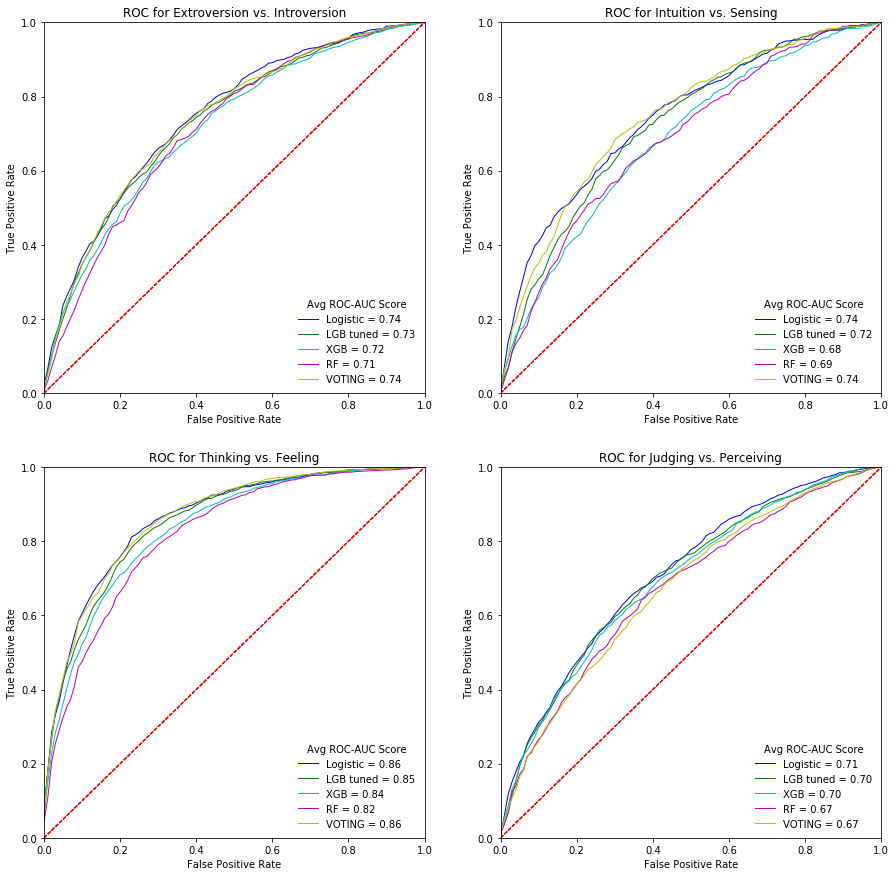

In [62]:
auc_plot(model_list, model_names, plot_type='roc')

In terms of ROC_AUC, Voting model performs the best.

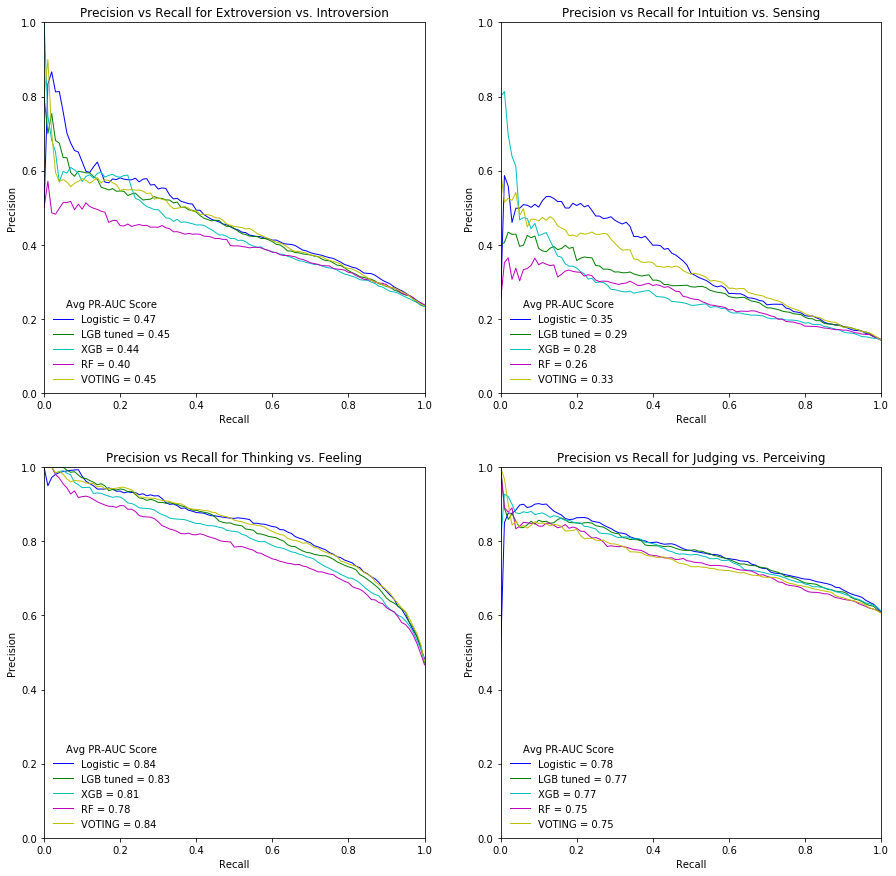

In [63]:
auc_plot(model_list, model_names, plot_type='pr')

In terms of PR_AUC, both voting model and Logistic regression are the best. However, in the perspective of stability, we would like to prefer voting model as our final model. For better highlight its stable performance, we also let its sub models join the Celebrities' Personality Prediction.

## **5.) Celebrities' Personality Prediction Based on Tweets**
Those posts data are scraped via Tweets API

### 5.1) Data Processing

In [113]:
cb = pd.read_csv('data/celeb_twitter_mbti.csv')
cb

,name,type,posts
0,Donald Trump,ESTP,My thoughts and prayers are with the @USMC cre...
1,Barack Obama,ENFJ,"Happy Hanukkah! Over these eight nights, we dr..."
2,Kanye West,ISFP,@jarrodspector @TheCherShow the dynamics of Ch...
3,Arnold Schwarzenegger,INTJ,Fantastic to spend some time with you teaming ...
4,Justin Bieber,ESFP,All love over here Aaron. You got my support||...
5,Kina Grannis,INFP,happiest of birthdays to this sweetest human i...
6,Kristen Bell,ENFP,NEW BOOK: “Congo Stories” shares the voices of...
7,Kim Kardashian,ISFJ,Very calm except for when she wants food lol S...
8,Lady Gaga,INFJ,#Enigma #GagaVegas https://t.co/lGl7cxSCAH|||#...
9,Elon Musk,INTJ,Tracking shot of Falcon water landing https://...


In [114]:
cb['EorI']= cb['type'].apply(lambda x:x[0])
cb['NorS']= cb['type'].apply(lambda x:x[1])
cb['TorF']= cb['type'].apply(lambda x:x[2])
cb['JorP']= cb['type'].apply(lambda x:x[3])
cb

,name,type,posts,EorI,NorS,TorF,JorP
0,Donald Trump,ESTP,My thoughts and prayers are with the @USMC cre...,E,S,T,P
1,Barack Obama,ENFJ,"Happy Hanukkah! Over these eight nights, we dr...",E,N,F,J
2,Kanye West,ISFP,@jarrodspector @TheCherShow the dynamics of Ch...,I,S,F,P
3,Arnold Schwarzenegger,INTJ,Fantastic to spend some time with you teaming ...,I,N,T,J
4,Justin Bieber,ESFP,All love over here Aaron. You got my support||...,E,S,F,P
5,Kina Grannis,INFP,happiest of birthdays to this sweetest human i...,I,N,F,P
6,Kristen Bell,ENFP,NEW BOOK: “Congo Stories” shares the voices of...,E,N,F,P
7,Kim Kardashian,ISFJ,Very calm except for when she wants food lol S...,I,S,F,J
8,Lady Gaga,INFJ,#Enigma #GagaVegas https://t.co/lGl7cxSCAH|||#...,I,N,F,J
9,Elon Musk,INTJ,Tracking shot of Falcon water landing https://...,I,N,T,J


In [115]:
cb['avg_comment_length'] = cb['posts'].apply(lambda x: len(x.split())/50)
cb['comment_length_var'] = cb['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [116]:
processed_post_p = post_preprocess(cb)

Processing... Be patient
Progress bar：100%


In [117]:
for i in range(3,7):
    cb.iloc[:,i] = cb.iloc[:,i].map(type_map)
cb.head()

,name,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,Donald Trump,ESTP,My thoughts and prayers are with the @USMC cre...,1,1,1,1,18.32,37.5700
1,Barack Obama,ENFJ,"Happy Hanukkah! Over these eight nights, we dr...",1,0,0,0,19.82,7.0400
2,Kanye West,ISFP,@jarrodspector @TheCherShow the dynamics of Ch...,0,1,0,1,3.88,43.5604
3,Arnold Schwarzenegger,INTJ,Fantastic to spend some time with you teaming ...,0,0,1,0,15.04,35.1396
4,Justin Bieber,ESFP,All love over here Aaron. You got my support||...,1,1,0,1,5.90,39.3056


### 5.2) Feature Engineering

In [118]:
word_tfidf_p = vectorizer_tfidf.transform(processed_post_p)
word_tfidf_df_p = pd.DataFrame(data = word_tfidf_p.toarray(), columns = vectorizer_tfidf.get_feature_names())
word_tfidf_df_p

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,across,...,year ago,year old,yep,yes,yesterday,yet,young,younger,youtube,yup
0,0.0,0.038985,0.072379,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.032951,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.102231,0.000000,0.310189,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089085,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.069567,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,0.0,0.000000,0.000000,0.055455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.031323,0.000000,0.044915,0.000000,0.0,0.0,0.0
7,0.0,0.043555,0.000000,0.052411,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.059206,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.128887,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [119]:
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(cb)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post_p[i])['compound']
    scores.append(score)
cb['Sentiment'] = scores

In [120]:
cb.head()

,name,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,Sentiment
0,Donald Trump,ESTP,My thoughts and prayers are with the @USMC cre...,1,1,1,1,18.32,37.5700,0.9990
1,Barack Obama,ENFJ,"Happy Hanukkah! Over these eight nights, we dr...",1,0,0,0,19.82,7.0400,0.9996
2,Kanye West,ISFP,@jarrodspector @TheCherShow the dynamics of Ch...,0,1,0,1,3.88,43.5604,0.9910
3,Arnold Schwarzenegger,INTJ,Fantastic to spend some time with you teaming ...,0,0,1,0,15.04,35.1396,0.9998
4,Justin Bieber,ESFP,All love over here Aaron. You got my support||...,1,1,0,1,5.90,39.3056,0.9987


In [121]:
# 
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in cb['posts']]
cb['Ellipses'] = ellipses_count
#
exclamation_count = [len(re.findall(r'!',posts)) for posts in cb['posts']]
cb['Exclamation'] = exclamation_count
#
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in cb['posts']]
# Append to dataframe
cb['Question'] = question_count
#
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in cb['posts']]
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
cb['Links'] = link_count
# picture and emo
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in cb['posts']]
cb['Picture'] = question_count
cb['Emojies'] = cb['posts'].map(lambda x: len(find_emoji(x)))
# Upper
temp = cb['posts'].apply(lambda x: del_punct(x))
cb['Upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))
# clean and scale
cb.fillna(value=0, inplace=True)
sentiment_scaled = min_max_scaler.transform(np.array(cb['Sentiment']).reshape(-1, 1))
cb['Sentiment'] = sentiment_scaled

In [122]:
# initialization
target_p = cb.iloc[:,3:7]
X_tf_p = pd.concat([cb.iloc[:,7:],word_tfidf_df_p],axis=1)

### 5.3) Prediction
Sub Model:
- Logestic Regression
- Random Forest
- LGBM
- XGBoost

Ensemble Model
- Voting Classifier

In [79]:
def print_result():
    trans_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]
    def translate_back(personality):
        s = ""
        for i, l in enumerate(personality):
            s += trans_list[i][l]
        return s
    type_p=[]
    target_col = [f'{col}_pred' for col in target_p.columns]
    for p in np.array(cb[target_col]):
        type_p.append(translate_back(p))
    cb['type_p'] = type_p
    return cb[['name','type','type_p']]

In [80]:
def acc_result(model):
    t = time.time()
    avg_acc = []
    for col in target_p.columns:
        print(f"*predicting {types[col]}..")
        y = target[col]
        y_p = target_p[col]
        model.fit(X_tf, y)
        cb[f'{col}_pred'] = model.predict(X_tf_p)
        avg_acc.append(accuracy_score(y_p,cb[f'{col}_pred']))
    print(f'Average Accuracy:{np.mean(avg_acc):.4f}; Time use:{time.time()-t:.2f}s')
    return print_result()

In [125]:
LR = LogisticRegression(class_weight='balanced')

acc_result(LR)

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.6818; Time use:7.66s


,name,type,type_p
0,Donald Trump,ESTP,ISFJ
1,Barack Obama,ENFJ,ISFJ
2,Kanye West,ISFP,ISFJ
3,Arnold Schwarzenegger,INTJ,ISFJ
4,Justin Bieber,ESFP,ESFJ
5,Kina Grannis,INFP,INFP
6,Kristen Bell,ENFP,ISFP
7,Kim Kardashian,ISFJ,ISFJ
8,Lady Gaga,INFJ,ISFJ
9,Elon Musk,INTJ,ISTJ


In [126]:
# since lgb takes different parameters each round, I treated it differently
para_list = [{'n_estimators': 400, 'bagging_fraction': 0.8, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.7, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
          {'n_estimators': 350, 'bagging_fraction': 0.5, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 15, 'boosting_type': 'gbdt', 'max_depth': 4, 'feature_fraction': 0.9, 'lambda_l1': 40, 'objective': 'binary', 'metric': 'auc'},
          {'n_estimators': 450, 'bagging_fraction': 0.5, 'learning_rate': 0.1, 'is_unbalance': True, 'max_bin': 18, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 20, 'objective': 'binary', 'metric': 'auc'},
          {'n_estimators': 450, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 5, 'boosting_type': 'gbdt', 'max_depth': 3, 'feature_fraction': 0.9, 'lambda_l1': 10, 'objective': 'binary', 'metric': 'auc'}]


t = time.time()
avg_acc = []
for i,col in enumerate(target.columns):
    print(f"*predicting {types[col]}..")
    param = para_list[i]
    y = target[col]
    y_p = target_p[col]
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_tf,y)
    cb[f'{col}_pred'] = gbm.predict(X_tf_p)
    avg_acc.append(accuracy_score(y_p,cb[f'{col}_pred']))
print(f'Average Accuracy:{np.mean(avg_acc):.3f}; Time use:{time.time()-t:.2f}s')
print_result()

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.591; Time use:43.45s


,name,type,type_p
0,Donald Trump,ESTP,INFJ
1,Barack Obama,ENFJ,INFJ
2,Kanye West,ISFP,ISFJ
3,Arnold Schwarzenegger,INTJ,ESFP
4,Justin Bieber,ESFP,ISFJ
5,Kina Grannis,INFP,ISFP
6,Kristen Bell,ENFP,ENTP
7,Kim Kardashian,ISFJ,ISTJ
8,Lady Gaga,INFJ,INFP
9,Elon Musk,INTJ,ISTJ


In [127]:
acc_result(RF)

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.5682; Time use:32.57s


,name,type,type_p
0,Donald Trump,ESTP,INTJ
1,Barack Obama,ENFJ,INFJ
2,Kanye West,ISFP,ISTJ
3,Arnold Schwarzenegger,INTJ,ESFJ
4,Justin Bieber,ESFP,ISFP
5,Kina Grannis,INFP,ISFP
6,Kristen Bell,ENFP,ISTP
7,Kim Kardashian,ISFJ,ISTJ
8,Lady Gaga,INFJ,INFP
9,Elon Musk,INTJ,ISTJ


In [128]:
acc_result(Lgbm)

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.6136; Time use:46.69s


,name,type,type_p
0,Donald Trump,ESTP,INFJ
1,Barack Obama,ENFJ,INFJ
2,Kanye West,ISFP,ISFJ
3,Arnold Schwarzenegger,INTJ,ESFJ
4,Justin Bieber,ESFP,ISFP
5,Kina Grannis,INFP,ESFP
6,Kristen Bell,ENFP,ENTP
7,Kim Kardashian,ISFJ,ISTJ
8,Lady Gaga,INFJ,INFP
9,Elon Musk,INTJ,ISTJ


In [129]:
acc_result(XGB)

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.6364; Time use:108.33s


,name,type,type_p
0,Donald Trump,ESTP,INFP
1,Barack Obama,ENFJ,INFP
2,Kanye West,ISFP,INFP
3,Arnold Schwarzenegger,INTJ,INFP
4,Justin Bieber,ESFP,INFP
5,Kina Grannis,INFP,INFP
6,Kristen Bell,ENFP,INTP
7,Kim Kardashian,ISFJ,INTJ
8,Lady Gaga,INFJ,INFP
9,Elon Musk,INTJ,INTJ


In [130]:
voting_clf = VotingClassifier(estimators = [('lgbm', Lgbm), 
                                            ('xgb', XGB),
                                            ('lr',LR),
                                            ('rf',RF)],
                              voting = 'soft')

In [131]:
acc_result(voting_clf)

*predicting Extroversion vs. Introversion..
*predicting Intuition vs. Sensing..
*predicting Thinking vs. Feeling..
*predicting Judging vs. Perceiving..
Average Accuracy:0.6364; Time use:209.95s


,name,type,type_p
0,Donald Trump,ESTP,INFJ
1,Barack Obama,ENFJ,INFJ
2,Kanye West,ISFP,ISFJ
3,Arnold Schwarzenegger,INTJ,ISFJ
4,Justin Bieber,ESFP,INFP
5,Kina Grannis,INFP,INFP
6,Kristen Bell,ENFP,ISTP
7,Kim Kardashian,ISFJ,ISFJ
8,Lady Gaga,INFJ,INFP
9,Elon Musk,INTJ,ISTJ


## **6.) Reflection:**

In this project, we developed classifiers for deriving a person’s Myers-Briggs type indicator (MBTI) by analyzing the forum posts written by them. To achieve this, we used two types of features: hand-crafted features and TFIDF vector features.

Hand-crafted features:
* Average comment length
* Comment length variance
* Average sentiment score
* Total number of ellipses (long posts that were truncated)
* Total number of exclamation marks
* Total number of question marks
* Total number of links
* Total number of links to pictures
* Total number of emojis
* Total number of upper case characters. 

The data was heavily imbalanced, with most people identifying as introverted (I) and Intuitive (N) rather than extroverted (E) and Sensitive (S).
Because of this, all the models we tried (Logarithmic Regression, Random Forest, Multinomial Naive Bayes, SVM, LightGBM, and XGBoost) had trouble classifying extroversion vs introversion and intuition vs sensitivity. However, when we made a Voting Classifier using Logarithmic Regression, Random Forest, LightGBM, and XGBoost, we were able to achieve the best AUC-ROC score and f-scores.

We used this Voting classifier to predict the MBTI personality types of famous people using their 50 most recent tweets. Actual MBTI types were gathered from various websites on the internet, so they may not be exact. The model was not able to predict all 4 letters correctly for all but one person, but it was able to predict at least 2 of the 4 letters correctly for all people. In total, we were able to correctly predict **63.6%** of all the letters for the MBTI types of all the -ROCfamous people.

Even for human-readers, it is hard to accurately predict a person's Myer-Briggs personality traits. However, our model was able to correctly classify around 2/3 of the personality dimensions of the MBTI types correctly for the test cases. While there is no way of determining whether  This indicates that it is possible to build a machine learning model for predicting one's MBTI personality traits from written text. 

In order to improve upon our prediction capabilities, scraping for more data in order to balance the classes and increase variability in our training set will be ideal. Furthermore, we could use different models that will better capture the latent patterns in our text data. For example, Recurrent Neural Networks with LSTM cells are able to capture long-term dependencies in sequences of text data. This capability may make it a better model for classifying our text data. 